First, let's load the dataset.

In [10]:
import pandas as pd

DATASET_PATH = "../data/docee/train_all.csv"
df = pd.read_csv(DATASET_PATH)
print(f"Loaded {len(df)} examples.")
df.head()

Loaded 21949 examples.


,index,index.3,index.2,index.1,title,text,event_type,arguments,date,metadata
0,0,0,0,0,Vietnam reelects conservative Nguyễn Phú Trọng...,Vietnam's Communist Party Wednesday re-elected...,Government Job change - Election,"[{'start': 0, 'end': 24, 'type': 'Candidates a...",January 2016,"['(AP via ABC News)', '(Channel NewsAsia)']"
1,1,1,1,1,At least 42 people are killed in a bus crash i...,Another 43 people were injured when the bus ca...,Road Crash,"[{'start': 8, 'end': 29, 'type': 'Casualties a...",October 2006,['(BBC)']
2,2,2,2,2,At least 27 migrants die in a shipwreck in the...,At least 27 migrants have died off the Turkish...,Shipwreck,"[{'start': 0, 'end': 29, 'type': 'Casualties a...",February 2016,"['(ANSAmed)', '(Leadership)', '(news.com.au)',..."
3,3,3,3,3,Colten Treu faces charges of vehicular homicid...,"Colten Treu, 21, and his roommate both told au...",Road Crash,"[{'start': 183, 'end': 207, 'type': 'Number of...",November 2018,"['(KSTP)', '(Oxygen)']"
4,4,4,4,4,"Hours after the announcement, Morales resigns ...",Bolivian President Evo Morales has resigned af...,Government Job change - Resignation_Dismissal,"[{'start': 0, 'end': 17, 'type': 'Position', '...",November 2019,"['(BBC News)', '(The Guardian)']"


Before proceeding, let's get rid of unnamed rows. This operation is idempotent, so it can safely be run multiple times.

In [11]:
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
df.to_csv(DATASET_PATH, index_label="index")

Now, let's split the dataset according to the presence of `data` attribute. Wiki articles do not have this attribute set, while news articles do.

In [12]:
df_news = df.loc[~df["date"].isna(), :]
print(f"Extracted {len(df_news)} news examples")

Extracted 12601 news examples


In [13]:
df_wiki = df.loc[df["date"].isna(), :]
print(f"Extracted {len(df_wiki)} wiki examples")

Extracted 9348 wiki examples


Let's check the class distribution.
We want to create a two-dimensional visual structure. One dimension represents the class name, while the other dimension represents the example count.

Class name is a categorical value, while example count is quantitative ordinal.
We can use a bar plot to show this.

Total of 59 class names.
Sum of all class counts equals 21949.


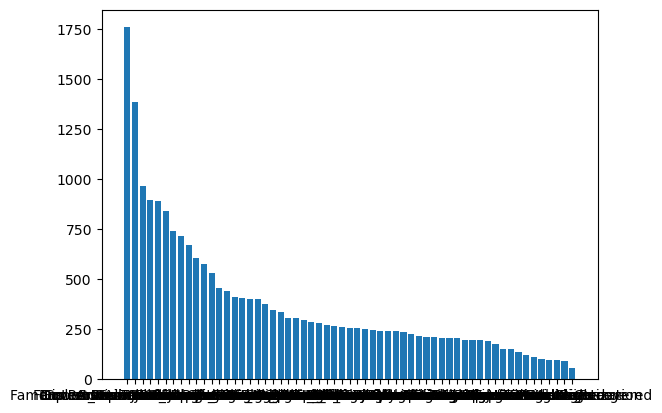

In [14]:
from src.utils import plot_class_distribution

plot_class_distribution(df)

Total of 54 class names.
Sum of all class counts equals 12601.


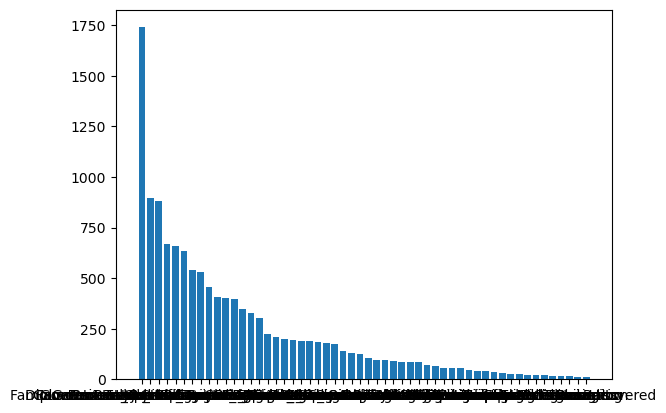

In [15]:
plot_class_distribution(df_news)

Total of 52 class names.
Sum of all class counts equals 9348.


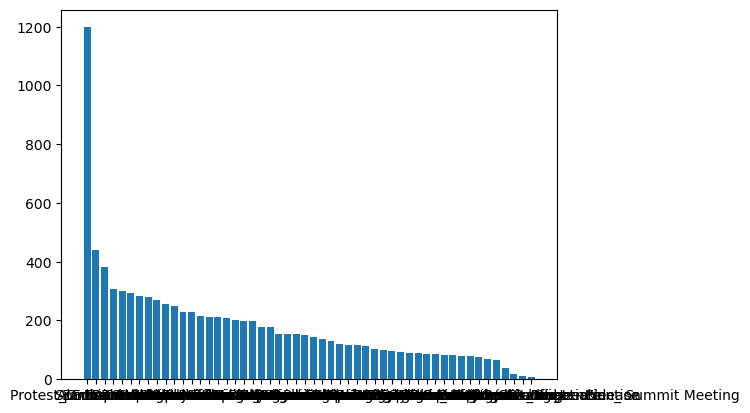

In [16]:
plot_class_distribution(df_wiki)

Since we initially want to augment only low-resource classes, we should specify a cutoff threshold and take only classes for which the example count is less than the threshold.

In [17]:
data = [["a", 1], ["b", 2], ["c", 3]]
columns = ["key", "value"]
dummy = pd.DataFrame(data, columns=columns)
dummy.loc[dummy["key"].isin(["a", "b"]), :]

,key,value
0,a,1
1,b,2


In [19]:
from src.utils import low_resource_slice

lr_news, lr_news_df = low_resource_slice(df_news, 250, return_classes=True)

Total of 54 class names.
Sum of all class counts equals 12601.


Once we have our low resource classes, we would like to compare event detection performance before and after augmentation.

The dataset will be augmented by adding, for each example, its summary as produced by a trained BART model. Such augmentation is performed under the assumption that the class label (i.e. event type) is unchanged if the document is summarized.

The research hypothesis that we're testing is as follows:
"If abstractive summarization is unsuccessful as an augmentation method for document-level event detection, then no statistically significant performance gains will be observed."

TODO: implement per-class evaluation of model performance
TODO: determine the procedure of testing for statistical significance.

As a final step of this prototyping notebook, we will do the following:
    1) load the training split
    2) for extraction_prodecure in (before newswiki, after newswiki):
        3) extract low-resource classes
        4) save the portion of the dataset

In [24]:
from src.data import NewsWikiSplit
from src.utils import news_wiki_split
from pprint import pprint
import os
from typing import TypeAlias, Callable

# extraction_strategy :: pd.DataFrame -> (Pd.DataFrame, pd.DataFrame)
ExtractionStrategy: TypeAlias = Callable[[pd.DataFrame], NewsWikiSplit]

def low_resource_dataset_pipeline(
        load_path: str,
        extraction_strategy: ExtractionStrategy,
        save_path: str
) -> None:
    # load dataset from the given path
    df = pd.read_csv(load_path)
    print(f"Pipeline loaded {len(df)} rows "
          f"from {load_path}")

    pprint(df.head())

    # extract news and wiki, according to some extraction strategy
    news_wiki_split = extraction_strategy(df)

    # save extracted datasets to save path
    news_save_path = os.path.join(save_path, "train_news.csv")
    news_wiki_split.news.to_csv(
        os.path.join(save_path, "train_news.csv"),
        index=False
    )
    print(f"Low reseource dataset pipeline saved news_df to {news_save_path}")

    wiki_save_path = os.path.join(save_path, "train_wiki.csv")
    news_wiki_split.wiki.to_csv(
        os.path.join(save_path, "train_wiki.csv"),
        index=False
    )
    print(f"Low reseource dataset pipeline saved wiki_df to {wiki_save_path}")


def extract_before_splitting(cutoff: int) -> ExtractionStrategy:
    def extraction_strategy(df: pd.DataFrame) -> NewsWikiSplit:
        return news_wiki_split(low_resource_slice(df, cutoff, return_classes=False))

    return extraction_strategy

def split_before_extracting(cutoff: int) -> ExtractionStrategy:
    def extraction_strategy(df: pd.DataFrame) -> NewsWikiSplit:
        return news_wiki_split(df).map(lambda x: low_resource_slice(x, cutoff, return_classes=False))
    return extraction_strategy


In [25]:
low_resource_dataset_pipeline(
    "../data/docee/18091999/train.csv",
    extract_before_splitting(cutoff=300),
    "../data/docee/low_resource_augmentation"
)

Pipeline loaded 17559 rows from ../data/docee/18091999/train.csv
   index                                              title  \
0      0  North Korea responds to nearby joint United St...   
1      1  5,300 people flee flames which thousands of fi...   
2      2            Trans-Canada Air Lines Flight 831 crash   
3      3  Severe drought conditions continue in Zimbabwe...   
4      4  Saudi Arabian blogger Raif Badawi, who has bee...   

                                                text         event_type  \
0  North Korea says it will use its "nuclear dete...  Military Exercise   
1  VANCOUVER — More than 100 new forest fires are...               Fire   
2  Trans-Canada Air Lines (TCA) Flight 831 was a ...          Air crash   
3  As severe drought conditions continue in Zimba...           Droughts   
4  Raif Badawi is the laureate of this year's Sak...    Awards ceremony   

                                           arguments           date  \
0  [{'start': 74, 'end': 75, 'type